In [8]:
# Установка зависимостей
#!pip install supervision opencv-python pillow matplotlib
#!pip install inference-sdk

In [9]:
# Импорт необходимых библиотек
import cv2
import supervision as sv
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from collections import Counter # Импортируем Counter для подсчета классов

# --- Блок 1: Подготовка данных ---

In [10]:
# Ссылка на тестовое изображение с животными.
# В реальном мониторинге экосистем здесь мог бы быть поток с камеры или путь к локальному файлу.
image_url = "https://avatars.mds.yandex.net/i?id=3a5270ba49f81a15493269893c8e5265_l-5210535-images-thumbs&n=13"

# --- Блок 2: Инициализация клиента Roboflow ---

In [11]:
# Создается экземпляр клиента для общения с Roboflow API.
# api_url указывает на серверлесс-инфраструктуру Roboflow.
# api_key (ваш API ключ) нужен для аутентификации запроса.
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="eh4oQxBhGQmIy1J9O18h"
)

# --- Блок 3: Выполнение инференса (предсказания) ---

In [12]:
# client.run_workflow отправляет изображение на сервер для обработки.
# workspace_name="pnagibin": имя рабочего пространства пользователя.
# workflow_id="find-lynxes-boars-wolves-bears-and-foxes": конкретная версия модели/воркфлоу, для обнаружения животных.
# images: словарь с изображениями. В данном случае передается URL.
# use_cache=False: принудительно обновляет определение воркфлоу (полезно при отладке).
result = client.run_workflow(
    workspace_name="pnagibin",
    workflow_id="find-lynxes-boars-wolves-bears-and-foxes",
    images={
        "image": image_url
    },
    use_cache=False 
)

# --- Блок 4: Загрузка и конвертация изображения ---

In [13]:
# Для визуализации нам нужно само изображение, а не ссылка.
# requests.get скачивает байты изображения.
response = requests.get(image_url)

# BytesIO превращает байты в файловый объект, понятный библиотеке PIL.
# .convert("RGB") гарантирует, что картинка будет в стандартном цветовом формате (без альфа-канала).
image = Image.open(BytesIO(response.content)).convert("RGB")

# Превращаем PIL-изображение в NumPy-массив, так как библиотека supervision и OpenCV работают с массивами.
image_np = np.array(image)

# --- Блок 5: Обработка результатов (Парсинг) ---

In [14]:
# Результат от API приходит в виде списка словарей (по одному на каждое отправленное изображение).
# Мы отправляли одно изображение, поэтому берем result[0].
prediction_data = result[0]

# Библиотека supervision (sv) значительно упрощает работу с результатами нейросетей.
# sv.Detections.from_inference автоматически разбирает сложный JSON-ответ от Roboflow.
# Он извлекает координаты рамок (bounding boxes), классы и уверенность модели.
# Важно: "predictions" - это ключ в словаре prediction_data, содержащий результаты детекции.
detections = sv.Detections.from_inference(prediction_data["predictions"])

# --- Блок 6: Настройка визуализации (Аннотаторы) ---

In [15]:
# BoxAnnotator отвечает за рисование прямоугольников вокруг найденных объектов.
box_annotator = sv.BoxAnnotator()

# LabelAnnotator отвечает за размещение текста (названия класса) над рамкой.
label_annotator = sv.LabelAnnotator()

# Формирование списка подписей.
# zip(...) объединяет имена классов и уверенность модели для каждого обнаруженного объекта.
# f-строка форматирует текст: "bird 0.85" (имя + уверенность с двумя знаками после запятых).
labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections.data["class_name"], detections.confidence)
]

# --- Блок 7: Отрисовка на изображении ---

In [16]:
# Сначала рисуем рамки на копии исходного изображения (image_np.copy()).
# Копия нужна, чтобы не "портить" исходный массив данных, если он понадобится позже чистым.
annotated_image = box_annotator.annotate(
    scene=image_np.copy(),
    detections=detections
)

# Затем поверх рамок добавляем текстовые метки, используя labels, созданные выше.
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

# --- Блок 8: Вывод результатов ---

ВНИМАНИЕ! В окрестностях населенных пунктов замечены **bear** в количестве **4** особей.


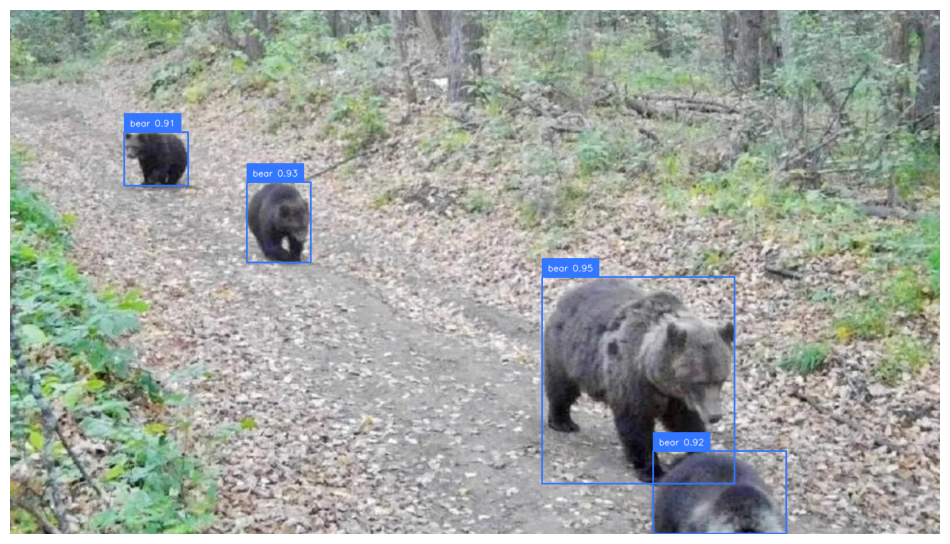

In [17]:


# 1. Получаем общее количество обнаруженных особей.
total_count = len(detections)

if total_count > 0:
    # 2. Получаем список всех распознанных классов.
    class_names = detections.data["class_name"]
    
    # 3. Считаем, какое название животного встречается чаще всего (наиболее репрезентативное).
    # Counter создает словарь вида {'имя_класса': количество, ...}
    # most_common(1) возвращает список с одним элементом: [('самый_частый_класс', количество)]
    most_common_class = Counter(class_names).most_common(1)[0][0]
    
    # 4. Форматируем вывод.
    output_message = f"ВНИМАНИЕ! В окрестностях населенных пунктов замечены **{most_common_class}** в количестве **{total_count}** особей."
else:
    output_message = "Животные на изображении не обнаружены."

# Вывод текстовой статистики.
print(output_message)

# Используем Matplotlib для показа изображения прямо в Jupyter Notebook или окне IDE.
plt.figure(figsize=(12, 12)) # Задаем большой размер фигуры для четкости.
plt.imshow(annotated_image)
plt.axis('off') # Убираем оси координат (пиксельную линейку), чтобы было красивее.
plt.show()